# Simple Example

Consider the following graphical Model,
```mermaid
flowchart TD
	S[(sigma)]--->X
	L[(lambda)]--->Z
	Z((Z))--->X[X]
```
Here we have a latent variable Z and a observed variable X. There are two controlling parameter $\sigma$ and $\lambda$ which are just included for completeness the more important relation ship is that of between $Z$ and $X$.
```mermaid
flowchart TD
	Z((Z))--->X[X]
```
Where,
$$
\begin{align}
Z &\sim Exp(\lambda)\\
X &\sim \mathcal{N}(\mu=Z,\sigma=1)
\end{align}
$$
and our task is to estimate $Z$ based on the observed $X$ that is we are interested in $p(Z|X)$.
$$
\begin{align}
p(Z) &= e^{-Z}\cdot I(Z\geq0)\\
p(X|Z) &= \frac{1}{{\sqrt{2\pi}}} e^{-\frac{\left({X - Z}\right)^2}{2}}
\end{align}
$$
Now,

$$
\begin{align}
p(X, Z) &= P(X|Z)P(Z)\\
&=e^{-Z}\cdot \frac{1}{{\sqrt{2\pi}}} e^{-\frac{\left({X - Z}\right)^2}{2}}I(Z\geq0)
\end{align}
$$
This gives us that that the marginal or total probability $p(X)$ is given by.

$$
\begin{align}
p(X) &= \int_0^\infty {p(X,Z)\; dZ}\\
&= \int_0^\infty {e^{-Z}\cdot \frac{1}{{\sqrt{2\pi}}} e^{-\frac{\left({X - Z}\right)^2}{2}}\; dZ}\\
\end{align}
$$


In [1]:
from scipy.stats import norm,expon
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact,widgets
from IPython.display import display
import sympy as sp
from sympy.parsing.latex import parse_latex

In [2]:
def prob_Z(Z):
    return expon.pdf(Z)
def prob_X_given_Z(X,Z):
    return norm.pdf(X,loc=Z,scale=1)

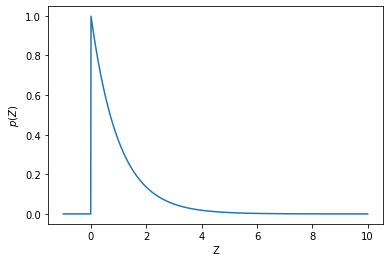

In [3]:
test_Z_space = np.linspace(-1,10,1000)
test_X_space = np.linspace(-10,10,1000)
# prob_Z(test_Z_space)
plt.ylabel('$p(Z)$')
plt.xlabel('Z')
plt.plot(test_Z_space,prob_Z(test_Z_space))
plt.show()

In [4]:
out = widgets.Output()
@interact(Z=(0,10))
def plot_x_given_Z(Z):
    prob = prob_X_given_Z(test_X_space,Z)
    with out:
        plt.ylabel('$p(X|Z)$')
        plt.xlabel('X')
        out.clear_output(wait=True)
        plt.plot(test_X_space,prob)
        plt.show()
display(out)

interactive(children=(IntSlider(value=5, description='Z', max=10), Output()), _dom_classes=('widget-interact',…

Output()

In [5]:
out = widgets.Output()
@interact(X=(-1.0,5.0))
def plot_Z_given_X_unnormalized(X):
    prob = prob_X_given_Z(X,test_Z_space)*prob_Z(test_Z_space)
    with out:
        plt.ylabel('$p^*(Z|X)$')
        plt.xlabel('Z')
        out.clear_output(wait=True)
        plt.plot(test_Z_space,prob)
        plt.show()
display(out)

interactive(children=(FloatSlider(value=2.0, description='X', max=5.0, min=-1.0), Output()), _dom_classes=('wi…

Output()

Just for fun let's consider the unnormalized version we can take any value of the form $Cp(X,Z)$, so we will take the following.

$$
\begin{align}
p(Z|X) &\propto e^{-Z}\cdot  e^{-\frac{\left({X - Z}\right)^2}{2}}I(Z\geq0)\\
 &\propto e^{-\frac{\left({X - Z}\right)^2}{2}-Z}I(Z\geq0)\\
 &\propto e^{-\frac{1}{2}{\left(X^2-2XZ+Z^2 - 2Z\right)}}I(Z\geq0)\\
 &\propto e^{-\frac{1}{2}{\left(Z - (X-1)\right)^2}}I(Z\geq0)\\
\end{align}
$$

In the last step I have completed the square with respect to Z and then gotten rid of the terms that depend only on X (separating out into a sperate exponential) as for a given X it is a constant.

This is a normal distribution!! (Apparent in the above illustration). If it weren't for the indicator function we could have easily found the normalizing constant however it's presence causes an issue (Of course we can use the Err Function or any CDF of the normal but this is a case where such precomputed functions exist in general this is not possible.)


Now as mentioned previously the goal is to find $q(z)$ such that it minimized the ELBO (or variational free energy).

$$
\begin{align}
\hat{q}(z) = \text{argmax}_q(\mathcal{L})
\end{align}
$$
>[!Attention]
>$\hat{q}$ reffers to the best estimate of q

where,
$$
\begin{align}
\mathcal{L} = \mathbb{E}_q \left[\ln\left(\frac{p(Z,X=D)}{q(Z)}\right)\right]
\end{align}
$$
This is calculus of variation problem and in general it is difficult to solve (anyway if we could solve it exactly we would get back the original distribution).


Therefore we impose a constraint on $q$ in the form a parametric distribution and optimize for the parameters instead.
In this case we will try an exponential distribution.

Therefore we impose a constraint on $q$ in the form a parametric distribution and optimize for the parameters instead.
In this case we will try an exponential distribution.
$$
\begin{align}
q_{\theta}(Z) &= Exp(Z;\lambda=\theta)\\
&= {\theta}e^{-\theta Z}\cdot I(Z\geq0)
\end{align}
$$



In [6]:
def surrogate(theta,Z):
    return expon.pdf(Z,scale=theta)
def kl_divergence(q,p):
    p = p/np.sum(p)
    q = q/np.sum(q)
    
    return np.sum(q*np.log(q/p))

In [7]:
out = widgets.Output()
@interact(X=(-1.0,5.0),theta=(0,10.0))
def plot_Z_and_surrogate(X,theta):
    prob = prob_X_given_Z(X,test_Z_space)*prob_Z(test_Z_space)
    true_prob = prob/np.sum(prob)*1000/11
    sur = surrogate(theta,test_Z_space)
    with out:
        out.clear_output(wait=True)
        plt.xlabel('Z')
        plt.plot(test_Z_space,sur,label='$q_theta(z)$')
        plt.plot(test_Z_space,true_prob,label='$p(Z|X)$')
        plt.legend()
        plt.show()
display(out)

interactive(children=(FloatSlider(value=2.0, description='X', max=5.0, min=-1.0), FloatSlider(value=5.0, descr…

Output()

Now let us calculate the ELBO using this surrogate distribution.
Instead of using the full distribution I will use $p^*$ as it only causes a constant change for a given $X$.
Note that for $Z<0$ the value of quantity will be 0 so we will only consider $Z\geq 0$ 
$$
\begin{align}
\ln(p^*(Z|X=D)) &= -\frac{1}{2}(Z - (D-1))^2\\
\ln(q_{\theta}(Z)) &= -\theta Z + \ln(\theta)\\
\mathcal{L} &= E_q\left[\theta Z-\ln(\theta) -\frac{1}{2}(Z - (D-1))^2\right]\\ 
&=-ln(\theta)+\theta E_q[Z]-\frac{1}{2}E_q[Z^2]+(D-1)E_q[Z]-\frac{1}{2}(D-1)^2\\
&= -ln(\theta)+\theta \frac{1}{\theta}-\frac{1}{2}\left(2\frac{1}{\theta^2}\right)+(D-1)\frac{1}{\theta}-\frac{1}{2}(D-1)^2\\
&= -ln(\theta)+1-\frac{1}{\theta^2}+(D-1)\frac{1}{\theta}-\frac{1}{2}(D-1)^2
\end{align}
$$

In order to maximize the ELBO we take its derivative with respect to $\theta$.

$$
\begin{align}
\frac{d\mathcal{L}}{d\theta} &=-\frac{1}{\theta} - \frac{D - 1}{\theta^{2}} + \frac{2}{\theta^{3}} \\
\text{setting  } \frac{d\mathcal{L}}{d\theta} &= 0\\
\implies -\theta^{2} + \theta \left(1 - D\right) + 2
\end{align}
$$
$$
\begin{align}
\implies \theta \in \left\{- \frac{D}{2} - \frac{\sqrt{D^{2} - 2 D + 9}}{2} + \frac{1}{2},- \frac{D}{2} + \frac{\sqrt{D^{2} - 2 D + 9}}{2} + \frac{1}{2}\right\}
\end{align}
$$
This can be written more neatly as,

$$
\begin{align}
\implies \theta \in \left\{-\frac{D-1}{2}-\sqrt{\frac{(D-1)^2}{4}+2}\;,\;
-\frac{D-1}{2}+\sqrt{\frac{(D-1)^2}{4}+2},\right\}
\end{align}
$$

If we name these two possibilities $\theta_1,\theta_2$ in that order, $\theta_1$ is always negative while $\theta_2$ is always positive. 

For an exponential distribution $\theta$ must be positive and it can be shown that it gives a maximum for the ELBO.

In [8]:
best_theta = lambda D : -(D-1)/2+np.sqrt((D-1)**2/4+2)
best_theta(1)

1.4142135623730951

In [9]:
out = widgets.Output()
@interact(X=(-1.0,5.0))
def plot_Z_and_best_surrogate(X):
    prob = prob_X_given_Z(X,test_Z_space)*prob_Z(test_Z_space)
    theta = best_theta(X)
    true_prob = prob/np.sum(prob)*1000/11
    sur = surrogate(theta,test_Z_space)
    with out:
        out.clear_output(wait=True)
        plt.xlabel('Z')
        plt.plot(test_Z_space,sur,label='$q_theta(z)$')
        plt.plot(test_Z_space,true_prob,label='$p(Z|X)$')
        plt.legend()
        plt.show()
        print(f"best theta: {theta}")

display(out)

interactive(children=(FloatSlider(value=2.0, description='X', max=5.0, min=-1.0), Output()), _dom_classes=('wi…

Output()

While it was possible to obtain a closed form expression for $\theta$ it is not possible in general and therefore, stochastic methods are needed for problems of the general case.